# Import Python Libraries

In [2]:
#Importing Python Libraries

#Import data libraries
import pandas as pd
import numpy as np 

#Import data visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

#Import data preprocessing modules
from sklearn.preprocessing import MultiLabelBinarizer

#Import machine learning preprocessing modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_validate

#Import machine learning models
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

#Import machine learning models metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Creating Dataframes

In [3]:
#Create DF and Clean Up
data = pd.read_csv("src/data/listings_Sep_22.csv")
data['host_response_rate'] = pd.to_numeric(data['host_response_rate'].str.replace("%",''))
data['instant_bookable'] = np.where(data['instant_bookable'] == 't', True, False)
data['price'] = data['price'].str.replace("$","")
data['price'] = pd.to_numeric(data['price'].str.replace(",",""))

/var/folders/sj/tbs4vnjn7h7f5_2xqbzb2r6c0000gn/T/ipykernel_4538/39304309.py:2: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("src/data/listings_Sep_22.csv")
/var/folders/sj/tbs4vnjn7h7f5_2xqbzb2r6c0000gn/T/ipykernel_4538/39304309.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['price'] = data['price'].str.replace("$","")


In [4]:
#Selecting columns to test
important_columns = [
    # 'description',
    'host_location',
    'host_response_time',
    'host_response_rate',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    # 'bathrooms_text',
    'bedrooms',
    'beds',
    # 'amenities',
    # 'availability_30',
    # 'availability_60',
    # 'availability_90',
    # 'availability_365',
    'instant_bookable',
    'price'
    ]
df = data[important_columns]

df.shape

(39881, 14)

In [5]:
#Dropping Duplicates
df = df.dropna().drop_duplicates().reset_index(drop=True)
df.shape

(18478, 14)

# EDA of Features

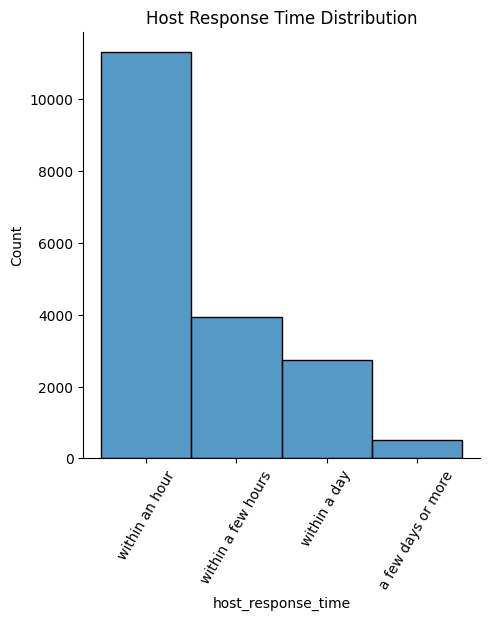

In [6]:
#Create distribution graph of host_response_time
sns.displot(data=df, x='host_response_time')
plt.xticks(rotation=60)
plt.title("Host Response Time Distribution")
plt.show()

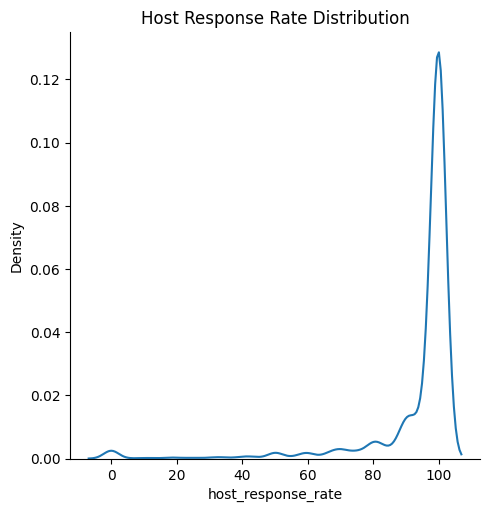

In [7]:
#Create distribution graph of host_response_rate
sns.displot(data=df, x='host_response_rate', kind="kde")
plt.title("Host Response Rate Distribution")
plt.show()

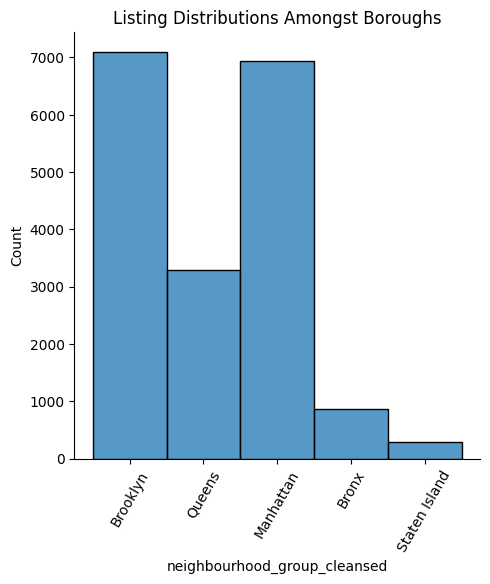

In [8]:
#Create distribution graph of neighbourhood_group_cleansed
sns.displot(data=df, x='neighbourhood_group_cleansed')
plt.xticks(rotation=60)
plt.title("Listing Distributions Amongst Boroughs")
plt.show()

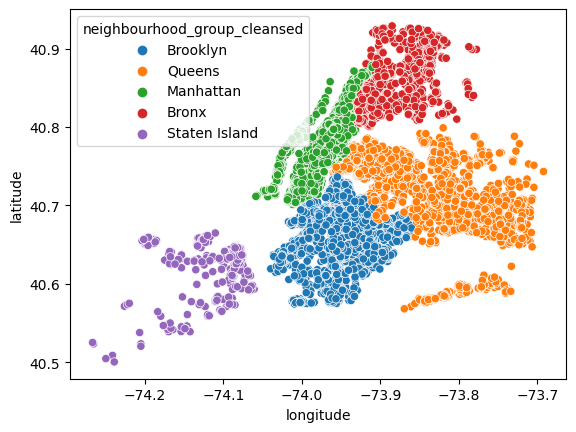

In [9]:
#Create scatter plot of listings
sns.scatterplot(data=df, y='latitude', x='longitude', hue='neighbourhood_group_cleansed')
plt.show()

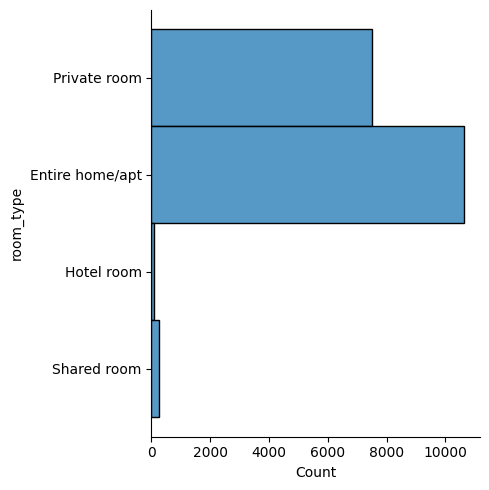

In [14]:
#Create distribution graph of room_type
sns.displot(data=df, y='room_type')
plt.show()

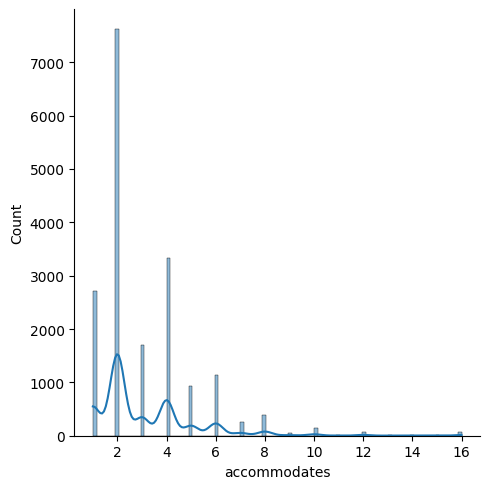

In [10]:
#Create distribution graph of accommodates
sns.displot(data=df, x='accommodates', kde=True)
plt.show()

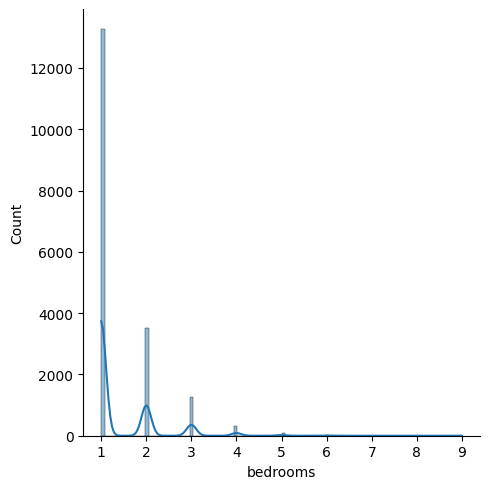

In [11]:
#Create distribution graph of bedrooms
sns.displot(data=df, x='bedrooms', kde=True)
plt.show()

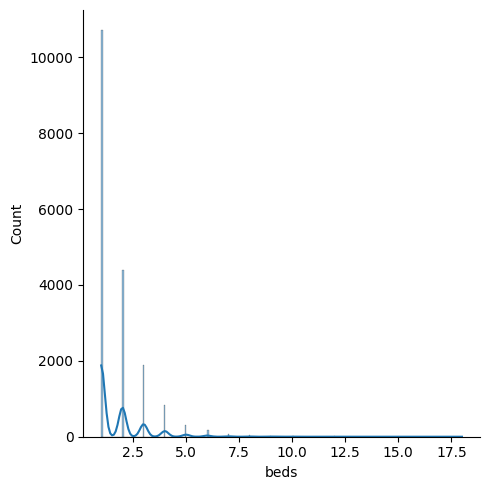

In [12]:
#Create distribution graph of beds
sns.displot(data=df, x='beds', kde=True)
plt.show()

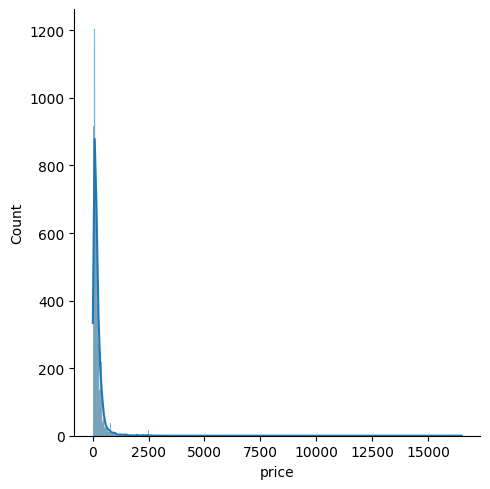

In [13]:
#Create distribution graph of price
sns.displot(data=df, x='price', kde=True)
plt.show()

# Feature Engineering

In [14]:
#Creating new columns
model_df = df.copy()
model_df = pd.get_dummies(model_df, columns=['instant_bookable'], drop_first=True)
model_df = pd.get_dummies(model_df, columns=['room_type','property_type'], drop_first=True)
model_df = pd.get_dummies(model_df, columns=['neighbourhood_cleansed','neighbourhood_group_cleansed'], drop_first=True)
model_df = pd.get_dummies(model_df, columns=['host_response_time'], drop_first=True)
model_df['host_location_in_ny'] = np.where(model_df['host_location'].str.contains("NY|New York"), True, False)
model_df.drop("host_location", axis=1, inplace=True)
model_df = pd.get_dummies(model_df, columns=['host_location_in_ny'], drop_first=True)
model_df.shape

(18478, 312)

# Creating Machine Learning Model

In [15]:
#Selecting X and y 
X = model_df.drop("price", axis=1).values #features
y = model_df["price"].values #target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape, y.shape)

(18478, 311) (18478,)


# Linear Regression

In [16]:
#Testing Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)

print("Train score: ",reg.score(X_train,y_train))
print("Testing score: ", reg.score(X_test,y_test))

Train score:  0.2416220495967093
Testing score:  -208177784114405.47


In [17]:
#Metrics for first model across entire dataset
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
reg = LinearRegression()
cv_scores = cross_validate(reg, X, y, cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))

for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])} \n")

r2 mean cross validate score: -2.758187063903483e+16 

neg_mean_squared_error mean cross validate score: -3.458868899237441e+21 

neg_root_mean_squared_error mean cross validate score: -52120344736.82707 

neg_mean_absolute_error mean cross validate score: -1228876219.5389209 



In [18]:
# Finding important features
features = model_df.drop("price", axis=1).columns
lasso = Lasso(alpha=0.3)
lasso.fit(X,y)

lasso_coef_df = pd.DataFrame({'feature': features , 'coef': lasso.coef_})

#top 30 most import features
lasso_coef_df[lasso_coef_df['coef'] > 0].sort_values('coef', ascending=False).reset_index(drop=True).head(10)

,feature,coef
0,property_type_Room in hotel,252.349223
1,neighbourhood_cleansed_Tribeca,198.854071
2,property_type_Room in boutique hotel,197.646509
3,neighbourhood_cleansed_SoHo,181.522117
4,neighbourhood_group_cleansed_Manhattan,142.033762
5,property_type_Private room in resort,98.054483
6,neighbourhood_cleansed_Longwood,97.235623
7,neighbourhood_cleansed_Flatiron District,89.508197
8,neighbourhood_cleansed_Lower East Side,77.149419
9,bedrooms,73.871829


In [19]:
# Selecting important features
threshold = 0.5
not_important_features = lasso_coef_df[(lasso_coef_df['coef'] > -threshold) & (lasso_coef_df['coef'] < threshold)]['feature'].values

#number of important features based on threshold var
print(f"{len(model_df.columns) - len(list(not_important_features))} features remain")

62 features remain


In [24]:
#Creating a new df to reference the reduced features
new_model_df = model_df.drop(not_important_features, axis=1)
new_model_df["price"] = model_df['price']

new_model_df.shape

(18478, 62)

In [21]:
#Testing Linear Regression with reduced features
X2 = new_model_df.drop("price", axis=1).values #features
y2 = model_df["price"].values #target

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

reg2 = LinearRegression()
reg2.fit(X_train2, y_train2)

print("Train score: ",reg2.score(X_train2,y_train2))
print("Testing score: ",reg2.score(X_test2,y_test2))

Train score:  0.2290339902149663
Testing score:  0.42459737568515377


In [22]:
#Metrics for first model across entire dataset with reduced features
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
reg = LinearRegression()
cv_scores = cross_validate(reg, X2, y2,cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])} \n")

r2 mean cross validate score: 0.26539352685979284 

neg_mean_squared_error mean cross validate score: -86439.45157181655 

neg_root_mean_squared_error mean cross validate score: -285.51768357225063 

neg_mean_absolute_error mean cross validate score: -102.08060951056953 



## Linear Regression Model Conclusion
The original dataset with 311 features did very poorly with a Linear Regression model as seen with Mean Squared Error being so high. We assume that we had a lot noise in our model intake therefore we decided to reduced our features down. We preformed regularization with a Lasso model where we looked at the coefficients tied to eat feature and removed features where the absolute value of the coefficients were less than 0.5. After reducing the number of features by almost 80%, we saw improvements in our four metrics: R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error

# KNN

In [23]:
#Testing with original features
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train, y_train)

print("Train score: ", neigh.score(X_train,y_train))
print("Testing score: ", neigh.score(X_test,y_test))

Train score:  0.5281229233766929
Testing score:  0.16518475027193968


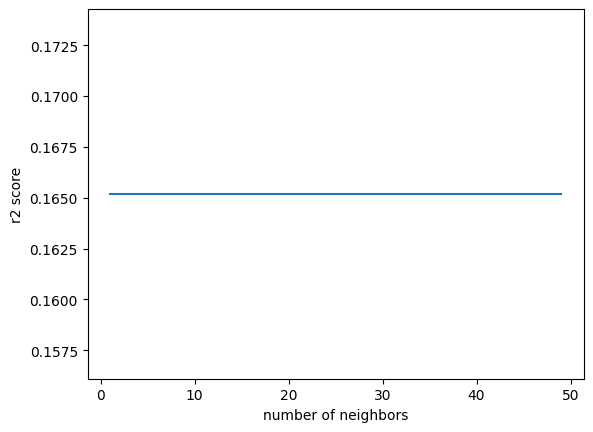

In [25]:
#Testing if the number of neighbors have any influence
ns = np.arange(1,50)
test_score = []
for n in ns:
    knn = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(X_train, y_train)
    test_score.append(neigh.score(X_test,y_test))

plt.plot(ns, test_score)
plt.xlabel('number of neighbors')
plt.ylabel('r2 score')
plt.show()

In [28]:
#Metrics for KNN model across entire dataset
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsRegressor(n_neighbors=3)
cv_scores = cross_validate(knn, X, y, cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])}")
    print("\n")

r2 mean cross validate score: 0.0917105176668807


neg_mean_squared_error mean cross validate score: -102844.67141014339


neg_root_mean_squared_error mean cross validate score: -314.50426677054793


neg_mean_absolute_error mean cross validate score: -86.99422612457457




In [27]:
#Testing with reduced features
neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train2, y_train2)

print("Train score: ", neigh.score(X_train2,y_train2))
print("Testing score: ", neigh.score(X_test2,y_test2))

Train score:  0.6083320902756371
Testing score:  0.34707241246324694


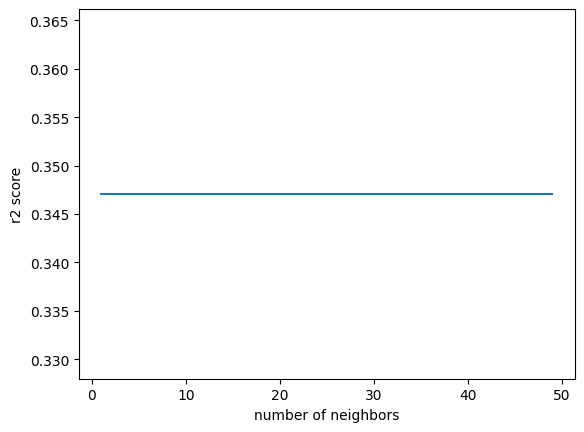

In [29]:
#Testing if the number of neighbors have any influence with reduced features
ns = np.arange(1,50)
test_score = []
for n in ns:
    knn = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(X_train2, y_train2)
    test_score.append(neigh.score(X_test2,y_test2))

plt.plot(ns, test_score)
plt.xlabel('number of neighbors')
plt.ylabel('r2 score')
plt.show()

In [30]:
#Metrics for KNN model across entire dataset with reduced features
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsRegressor(n_neighbors=3)
cv_scores = cross_validate(knn, X2, y2,cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])}")
    print("\n")

r2 mean cross validate score: 0.24031213313988933


neg_mean_squared_error mean cross validate score: -88386.07405375033


neg_root_mean_squared_error mean cross validate score: -289.5102373309378


neg_mean_absolute_error mean cross validate score: -85.40243264854226




## KNN Model Conclusion
The original dataset with 311 features did very poorly with a KNN model as seen with Mean Squared Error being so high. We also assume that we had a lot noise in our model intake therefore we decided to reduced our features down. We used the same 62 features used in last model therefore we saw improvements in our four metrics: R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error. It was wasn't as great as the Linear Regression model. We assume that we still needed to scale our features since KNN used distance making decisions. Maybe after scaling our features we could see improvements that are similar or better than Linear Regression

# Decision Tree

In [40]:
#Testing with original features
regressor = DecisionTreeRegressor(random_state=42, max_depth=8).fit(X_train, y_train)
print("Train score: ", regressor.score(X_train,y_train))
print("Testing score: ", regressor.score(X_test,y_test))

Train score:  0.7185429922527558
Testing score:  -0.11345722714454709


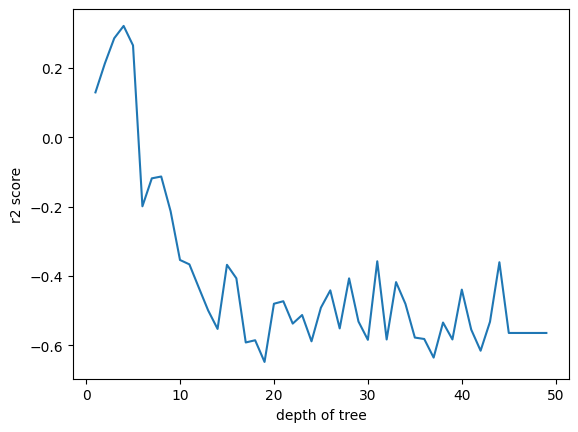

In [33]:
#Testing if the depth of the tree have any influence on test scores
ns = np.arange(1,50)
test_score = []
for n in ns:
    regressor = DecisionTreeRegressor(random_state=42, max_depth=n)
    regressor.fit(X_train, y_train)
    test_score.append(regressor.score(X_test,y_test))

plt.plot(ns, test_score)
plt.xlabel('depth of tree')
plt.ylabel('r2 score')
plt.show()

In [34]:
#Metrics for decision tree model across entire dataset 
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt = DecisionTreeRegressor(random_state=42, max_depth=8)
cv_scores = cross_validate(dt, X, y, cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])} \n")

r2 mean cross validate score: 0.067703988183704 

neg_mean_squared_error mean cross validate score: -106270.40447013138 

neg_root_mean_squared_error mean cross validate score: -317.7391763608807 

neg_mean_absolute_error mean cross validate score: -90.92364657445016 



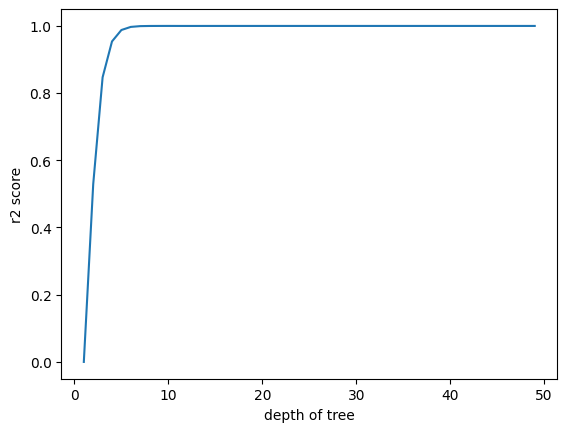

In [42]:
#Testing if the depth of the tree have any influence on test scores with reduced features
ns = np.arange(1,50)
test_score = []
for n in ns:
    regressor = DecisionTreeRegressor(random_state=42, max_depth=n)
    regressor.fit(X_train2, y_train2)
    test_score.append(regressor.score(X_test2,y_test2))

plt.plot(ns, test_score)
plt.xlabel('depth of tree')
plt.ylabel('r2 score')
plt.show()

In [39]:
#Testing with reduced features
regressor = DecisionTreeRegressor(random_state=42, max_depth=8).fit(X_train2, y_train2)
print("Train score: ", regressor.score(X_train2,y_train2))
print("Testing score: ", regressor.score(X_test2,y_test2))

Train score:  0.6657934206206981
Testing score:  -1.4546798241138372


In [38]:
#metrics for decision tree model across entire dataset with reduced features
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
dt = DecisionTreeRegressor(random_state=42, max_depth=8)
cv_scores = cross_validate(dt, X2, y2,cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])} \n")

r2 mean cross validate score: -0.07501541106415766 

neg_mean_squared_error mean cross validate score: -98938.88984649707 

neg_root_mean_squared_error mean cross validate score: -312.0006399989794 

neg_mean_absolute_error mean cross validate score: -92.1526949597733 



## Decision Tree Model Conclusion
The original dataset with 311 features did better with a KNN model when compared to Linear Regression and KNN models only with the R^2 being higher for the train data split while doing poorly with new data. This means that the Decision Tree model is prone to overfiting which can be seen with graphs relating the depth of a tree with it's R^2 score on new data. We assume that we had a lot noise in our model intake therefore we decided to reduced our features down. We used the same 62 features used in last model and saw improvements in our four metrics: R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error. It was wasn't as great as the Linear Regression model. We assume we still need to change some hyper parameters or alpha in our Lasso model; and that could result in improvements that could be similar or better than Linear Regression.

# Overall Conclusion
From testing Linear Regression, KNN, and Decision Tree models, we know that there are features that are less important since after reducing the number of features by 80% we see a major improvements in R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error scores. Maybe if we change the threshold from 0.5 down to 0.1 or up to 1.5 we could see improvements but only marginally small ones. Another thing we can do is change the alpha value for the Lasso model that highlights less important features. As for now, the Linear Regression model is our best model to accurately predict a listing price in New York City with R^2 score of 0.26.

# Testing bathrooms_text with Linear Regression

In [41]:
#Selecting columns to test including bathroom_text
important_columns = [
    # 'description',
    'host_location',
    'host_response_time',
    'host_response_rate',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms_text',
    'bedrooms',
    'beds',
    # 'amenities',
    # 'availability_30',
    # 'availability_60',
    # 'availability_90',
    # 'availability_365',
    'instant_bookable',
    'price'
]
df_with_bathrooms = data[important_columns]

df_with_bathrooms.shape

(39881, 15)

In [42]:
#Dropping Duplicates and NaN
df_with_bathrooms = df_with_bathrooms.dropna(subset=['bathrooms_text'])
df_with_bathrooms = df_with_bathrooms.dropna().drop_duplicates().reset_index(drop=True)

df_with_bathrooms.shape

(18472, 15)

### Feature Engineering with bathroom_text Column

In [43]:
#Creating helper functions
def getSharedStatus(data):
    return ('shared' in data or 'Shared' in data)

def getHalfBathStatus(data):
    return ('half-bath' in data)

def getPrivateStatus(data):
    return ('Private' in data)

def getNumberofBathrooms(data):
    splits = data.split(" ")[0]
    num = splits[0]
    try:
        num = int(num)
        return num
    except:
        return 1

In [44]:
#Creating new columns

#feature engineering from existing columns
df_with_bathrooms = pd.get_dummies(df_with_bathrooms, columns=['instant_bookable'], drop_first=True)
df_with_bathrooms = pd.get_dummies(df_with_bathrooms, columns=['room_type','property_type'], drop_first=True)
df_with_bathrooms = pd.get_dummies(df_with_bathrooms, columns=['neighbourhood_cleansed','neighbourhood_group_cleansed'], drop_first=True)
df_with_bathrooms = pd.get_dummies(df_with_bathrooms, columns=['host_response_time'], drop_first=True)

#feature engineering from created columns
df_with_bathrooms['host_location_in_ny'] = np.where(df_with_bathrooms['host_location'].str.contains("NY|New York"), True, False)
df_with_bathrooms.drop("host_location", axis=1, inplace=True)
df_with_bathrooms = pd.get_dummies(df_with_bathrooms, columns=['host_location_in_ny'], drop_first=True)

#feature engineering the bathrooms_text column
df_with_bathrooms['bathroomShared'] = df_with_bathrooms['bathrooms_text'].apply(getSharedStatus)
df_with_bathrooms['isBathroomHalf'] = df_with_bathrooms['bathrooms_text'].apply(getHalfBathStatus)
df_with_bathrooms['isBathroomPrivate'] = df_with_bathrooms['bathrooms_text'].apply(getPrivateStatus)
df_with_bathrooms['numberOfBathrooms'] = df_with_bathrooms['bathrooms_text'].apply(getNumberofBathrooms)
df_with_bathrooms.drop('bathrooms_text', axis=1, inplace=True)

In [52]:
#Recapturing data features and target
X_with_bathrooms = df_with_bathrooms.drop('price', axis=1).values #features
y_with_bathrooms = df_with_bathrooms["price"].values #target

X_train_with_bathrooms, X_test_with_bathrooms, y_train_with_bathrooms, y_test_with_bathrooms = train_test_split(X_with_bathrooms, y_with_bathrooms, test_size=0.2, random_state=42)

In [53]:
#Testing Linear Regression
reg = LinearRegression()
reg.fit(X_train_with_bathrooms, y_train_with_bathrooms)

print("Train score: ",reg.score(X_train_with_bathrooms,y_train_with_bathrooms))
print("Testing score: ", reg.score(X_test_with_bathrooms,y_test_with_bathrooms))

Train score:  0.28871892200519234
Testing score:  -7.053464957885378e+16


In [54]:
#Metrics for best model across entire dataset with bathroom features included
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
bath_reg = LinearRegression()
cv_scores = cross_validate(bath_reg, X_with_bathrooms, y_with_bathrooms,cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])}")
    print("\n")

r2 mean cross validate score: -1.1541144848473574e+17


neg_mean_squared_error mean cross validate score: -1.0113724804598763e+22


neg_root_mean_squared_error mean cross validate score: -83013824451.06995


neg_mean_absolute_error mean cross validate score: -2236953802.9982233




In [47]:
# Finding if bathroom features are important

# finding important features
features = df_with_bathrooms.drop("price", axis=1).columns
lasso = Lasso(alpha=0.3)
lasso.fit(X_with_bathrooms,y_with_bathrooms)

lasso_coef_df_with_bathrooms = pd.DataFrame({'feature': features , 'coef': lasso.coef_})

bathroom_features = ['bathroomShared', 'isBathroomHalf', 'isBathroomPrivate','numberOfBathrooms']
for feature in bathroom_features:
    display(lasso_coef_df_with_bathrooms[lasso_coef_df_with_bathrooms['feature'] == feature].reset_index(drop=True))

,feature,coef
0,bathroomShared,-33.29386


,feature,coef
0,isBathroomHalf,-0.0


,feature,coef
0,isBathroomPrivate,0.0


,feature,coef
0,numberOfBathrooms,161.950647


In [48]:
#Finding bathroom features affect on listing cost
X_train, X_test, y_train, y_test = train_test_split(X_with_bathrooms, y_with_bathrooms, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
bathroom_index = [list(df_with_bathrooms.drop('price', axis=1).columns).index(f) for f in bathroom_features]
for i, value in enumerate(bathroom_index):
    print(f"{bathroom_features[i]} add {reg.coef_[value]} dollars to listing")

bathroomShared add -13.934326171875 dollars to listing
isBathroomHalf add -24.32806396484375 dollars to listing
isBathroomPrivate add 42.882110595703125 dollars to listing
numberOfBathrooms add 163.4474172592163 dollars to listing


In [49]:
#Selecting important features

# finding less important features
threshold = 0.05
not_important_features_with_bathrooms = lasso_coef_df_with_bathrooms[(lasso_coef_df_with_bathrooms['coef'] > -threshold) & (lasso_coef_df_with_bathrooms['coef'] < threshold)]['feature'].values

#number of important features based on threshold var
print(f"{len(df_with_bathrooms.columns) - len(list(not_important_features))} features remain")

66 features remain


In [55]:
#Creating a new df to reference the new features
new_df_with_bathrooms = df_with_bathrooms.drop(not_important_features, axis=1)

#testing with reduced features
X2_with_bathrooms = new_df_with_bathrooms.drop('price',axis=1).values #features
y2_with_bathrooms = new_df_with_bathrooms["price"].values #target

X_train2_with_bathrooms, X_test2_with_bathrooms, y_train2_with_bathrooms, y_test2_with_bathrooms = train_test_split(X2_with_bathrooms, y2_with_bathrooms, test_size=0.2, random_state=42)

In [56]:
#Testing Linear Regression with reduced features
reg = LinearRegression()
reg.fit(X_train2_with_bathrooms, y_train2_with_bathrooms)

print("Train score: ",reg.score(X_train2_with_bathrooms,y_train2_with_bathrooms))
print("Testing score: ", reg.score(X_test2_with_bathrooms,y_test2_with_bathrooms))

Train score:  0.2767711958123762
Testing score:  0.2872824185858026


In [51]:
#Metrics for best model across entire dataset with reduced features and bathroom features included
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
bath_reg = LinearRegression()
cv_scores = cross_validate(bath_reg, X2_with_bathrooms , y2_with_bathrooms,cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])}")
    print("\n")

r2 mean cross validate score: 0.3026985174677896


neg_mean_squared_error mean cross validate score: -82711.39073527226


neg_root_mean_squared_error mean cross validate score: -277.2044403474942


neg_mean_absolute_error mean cross validate score: -100.68013858645006




# Bathroom Conclusions
After creating new features centered around the bathroom (is bathroom a half bath, is bathroom private, numberOfBathrooms, and is bathroom shared) we tested with Linear Regression model that had these some of the important bathroom features in it. The results from these test was it provided more confusion in our model which seems the out of character as one may assume that the number of bathrooms would have influence on listing price. Maybe changing the threshold to number higher could improve our model but we will need to test that further. As from our current testing, the two important features improves our model R^2 score by 0.04 when compared to a model without these bathroom features.

### Testing amenities with Linear Regression

In [57]:
#Selecting columns to test including amenities
important_columns = [
    # 'description',
    'host_location',
    'host_response_time',
    'host_response_rate',
    'host_neighbourhood',
    'neighbourhood_cleansed',
    'neighbourhood_group_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    # 'bathrooms_text',
    'bedrooms',
    'beds',
    'amenities',
    # 'availability_30',
    # 'availability_60',
    # 'availability_90',
    # 'availability_365',
    'instant_bookable',
    'price'
    ]
df_with_amenities = data[important_columns]

df_with_amenities.shape

(39881, 16)

In [58]:
#Dropping Duplicates and NaN
df_with_amenities = df_with_amenities.dropna().drop_duplicates().reset_index(drop=True)
df_with_amenities.shape

(15189, 16)

### Feature Engineering with amenities Column

In [59]:
#Capturing Amenities
amenities = {}
for amenities_set in df_with_amenities.amenities.values:
    amenities_set = amenities_set.strip('][').replace('"',"").split(', ')
    for item in amenities_set:
        amenities[item] = amenities.get(item, 0) + 1
        
#number of unique amenities
print("number of unique amenities", len(amenities.keys()))

number of unique amenities 3359


In [60]:
#Creating new columns

#feature engineering from existing columns
df_with_amenities = pd.get_dummies(df_with_amenities, columns=['instant_bookable'], drop_first=True)
df_with_amenities = pd.get_dummies(df_with_amenities, columns=['room_type','property_type'], drop_first=True)
df_with_amenities = pd.get_dummies(df_with_amenities, columns=['neighbourhood_cleansed','neighbourhood_group_cleansed'], drop_first=True)
df_with_amenities = pd.get_dummies(df_with_amenities, columns=['host_response_time','host_neighbourhood'], drop_first=True)

#feature engineering from created columns
df_with_amenities['host_location_in_ny'] = np.where(df_with_amenities['host_location'].str.contains("NY|New York"), True, False)
df_with_amenities.drop("host_location", axis=1, inplace=True)
df_with_amenities = pd.get_dummies(df_with_amenities, columns=['host_location_in_ny'], drop_first=True)

#feature engineering with amenities column
list_function = lambda row: row.strip('][').replace('"',"").split(', ')
df_with_amenities['amenities'] = df_with_amenities.amenities.apply(list_function)
mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(df_with_amenities['amenities']),columns=mlb.classes_, index=df_with_amenities.index)
df_with_amenities = df_with_amenities.join(amenities_df)
df_with_amenities.drop(['amenities'], axis=1, inplace=True)

df_with_amenities.shape

(15189, 4105)

In [61]:
#Recapturing data features and target
X_with_amenities = df_with_amenities.drop('price', axis=1).values #features
y_with_amenities = df_with_amenities["price"].values #target

X_train_with_amenities, X_test_with_amenities, y_train_with_amenities, y_test_with_amenities = train_test_split(X_with_amenities, y_with_amenities, test_size=0.2, random_state=42)

In [62]:
#Testing Linear Regression
reg = LinearRegression()
reg.fit(X_train_with_amenities, y_train_with_amenities)

print("Train score: ",reg.score(X_train_with_amenities,y_train_with_amenities))
print("Testing score: ", reg.score(X_test_with_amenities,y_test_with_amenities))

Train score:  0.604302799423426
Testing score:  -7.398127725481997e+19


In [63]:
# Metrics for best model across entire dataset with amenities features included
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
am_reg = LinearRegression()
cv_scores = cross_validate(am_reg, X_with_amenities, y_with_amenities,cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])}")
    print("\n")

r2 mean cross validate score: -1.4034504960592105e+18


neg_mean_squared_error mean cross validate score: -1.4445751681784806e+23


neg_root_mean_squared_error mean cross validate score: -319835534764.3033


neg_mean_absolute_error mean cross validate score: -32040191358.29186




In [64]:
#Finding important features
features = df_with_amenities.drop("price", axis=1).columns
lasso = Lasso(alpha=0.3)
lasso.fit(X_with_amenities,y_with_amenities)
lasso_coef_df_with_amenities = pd.DataFrame({'feature': features , 'coef': lasso.coef_})
lasso_coef_df_with_amenities[lasso_coef_df_with_amenities['coef'] > 0].sort_values('coef', ascending=False).reset_index(drop=True).head(10)

,feature,coef
0,Facial rice soap and Sandal Wood Soap. body soap,10817.877457
1,host_neighbourhood_Downtown Vancouver,4419.439366
2,host_neighbourhood_Foxhurst,698.885628
3,32\ TV,489.073215
4,host_neighbourhood_Clearwater Beach,325.286584
5,Various conditioner,275.168059
6,neighbourhood_cleansed_SoHo,181.321475
7,property_type_Room in hotel,151.866632
8,neighbourhood_group_cleansed_Manhattan,143.673416
9,Gym,112.952855


In [65]:
#Finding amenities features affect on listing cost
X_train, X_test, y_train, y_test = train_test_split(X_with_amenities, y_with_amenities, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)

lasso_coef_df_with_amenities['value'] = lasso_coef_df_with_amenities['feature'].apply(lambda x: reg.coef_[list(df_with_amenities.drop('price', axis=1).columns).index(x)])

lasso_coef_df_with_amenities[lasso_coef_df_with_amenities['coef'] > 0].sort_values('coef', ascending=False).reset_index(drop=True).head(10)

,feature,coef,value
0,Facial rice soap and Sandal Wood Soap. body soap,10817.877457,1.350663e+11
1,host_neighbourhood_Downtown Vancouver,4419.439366,8.701405e+03
2,host_neighbourhood_Foxhurst,698.885628,1.180787e+03
3,32\ TV,489.073215,9.882417e+02
4,host_neighbourhood_Clearwater Beach,325.286584,1.337034e+02
5,Various conditioner,275.168059,3.048241e+03
6,neighbourhood_cleansed_SoHo,181.321475,2.878926e+12
7,property_type_Room in hotel,151.866632,-2.252617e+12
8,neighbourhood_group_cleansed_Manhattan,143.673416,-2.878926e+12
9,Gym,112.952855,1.263667e+02


In [66]:
#Selecting important features

# finding less important features
threshold = 0.05
not_important_features_with_amenities = lasso_coef_df_with_amenities[(lasso_coef_df_with_amenities['coef'] > -threshold) & (lasso_coef_df_with_amenities['coef'] < threshold)]['feature'].values

#number of important features based on threshold var
print(f"{len(df_with_amenities.columns) - len(list(not_important_features))} features remain")

3855 features remain


In [67]:
#Creating a new df to reference the new features 
new_df_with_amenities = df_with_amenities.drop(not_important_features_with_amenities, axis=1)

#testing with reduced features
X2_with_amenities = new_df_with_amenities.drop('price',axis=1).values #features
y2_with_amenities = new_df_with_amenities["price"].values #target

X_train2_with_amenities, X_test2_with_amenities, y_train2_with_amenities, y_test2_with_amenities = train_test_split(X2_with_amenities, y2_with_amenities, test_size=0.2, random_state=42)

In [68]:
#Testing Linear Regression with reduced features
reg = LinearRegression()
reg.fit(X_train2_with_amenities, y_train2_with_amenities)

print("Train score: ",reg.score(X_train2_with_amenities,y_train2_with_amenities))
print("Testing score: ", reg.score(X_test2_with_amenities,y_test2_with_amenities))

Train score:  0.5299826391956179
Testing score:  0.457712118543272


In [69]:
# Metrics for best model across entire dataset with amenities features included
tests = ['r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error']
kf = KFold(n_splits=5, shuffle=True, random_state=42)
am_reg = LinearRegression()
cv_scores = cross_validate(am_reg, X2_with_amenities, y2_with_amenities,cv=kf, scoring=('r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error'))
for test in tests:
    print(test+f" mean cross validate score: {np.mean(cv_scores['test_' + test])} \n")

r2 mean cross validate score: 0.3104893653757655 

neg_mean_squared_error mean cross validate score: -76002.55727091854 

neg_root_mean_squared_error mean cross validate score: -261.89044133840343 

neg_mean_absolute_error mean cross validate score: -91.9058253768693 



# Amenities Conclusions
After creating new features centered around amenities we tested with Linear Regression model that had these some of the important Amenities features in it. The results from these test was it provided more confusion in our model which seems the out of character as one may assume that the number of bathrooms would have influence on listing price. Maybe changing the threshold to number higher could improve our model but we will need to test that further. Another thing to look at is maybe clustering Amenities into types instead of the individual amenities since that may reduced noise. As for now our best model that includes the amenities, its R^2 score for new data is better than a model without the amenities by 0.5.